# Main

This jupyter notebook aims at giving a `craft_ai.pandas` use case to the user.

The work is based on the dataset `yellow.csv` located in the directory _data/_. (It is possible to regenerate this dataset by using the notebook `Preprocessing.ipynb`.)

`yellow.csv` has been extracted from the data available on the ___NYC Taxi and Limousine Commission (LTC)___ [webpage](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page).

__Goal__:
The user is a NYC taxi driver who wants to know in the next hours where to drive to maximize his chances to find a client. 

In [1]:
import craft_ai.pandas
import pandas as pd
import numpy as np
import os

from Tools import plot_zone_results, plot_matshow

import matplotlib.pyplot as plt

In [2]:
FIGSIZE = (17, 5)
FONT = {"family": "sans-serif", "weight": "normal", "size": 16}

## 1. `Yellow` dataset handling

### 1.1. Load `yellow` Dataset

`yellow` contains the number of yellow taxis hired for each `taxi_zone` at a hourly time for the whole year 2017.
Columns names refer to zone ids, and the whole dataframe is indexed on time. The column `timezone` is needed to indicate the index timezone (which is New York).

In [3]:
PATH = '../data/' # Modify this to fit your data folder

In [4]:
yellow = pd.read_csv(PATH + "yellow.csv")
yellow.columns = yellow.columns[1:].insert(0, "timestamp")
yellow.timestamp = pd.to_datetime(yellow.timestamp, utc=True)
yellow.set_index("timestamp", drop=True, inplace=True)
yellow.index = yellow.index.tz_convert("America/New_York")

yellow.head(2)

,timezone,1,2,3,4,5,6,7,8,9,...,256,257,258,259,260,261,262,263,264,265
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00-05:00,-05:00,2.0,0.0,0.0,54.0,0.0,0.0,66.0,0.0,0.0,...,50.0,1.0,0.0,2.0,49.0,23.0,35.0,133.0,135.0,13.0
2017-01-01 01:00:00-05:00,-05:00,2.0,0.0,0.0,36.0,0.0,0.0,54.0,1.0,0.0,...,30.0,0.0,4.0,2.0,31.0,17.0,49.0,106.0,86.0,10.0


### 1.2. Focus on Queens areas (Recommended)

__If you want to compute all the taxi zones, skip the following cell.__

To save computation time, we only focus on 5 of the 69 Queens taxi zones.

<img src="http://www.nyc.gov/html/tlc/images/features/taxi_zone_map_queens.jpg" title="Queens Taxi Zones" alt="Bronx Taxi Zones" style="width: 300px;"/>

The selected taxi zones are the following: $7$, $145$, $146$, $193$, $226$ (NW areas).

In [5]:
selected_zones = [7, 145, 146, 193, 226] # Modify this list to fit your needs
selected_zones_str = [str(z) for z in selected_zones]

columns = ["timezone"] + selected_zones_str
yellow = yellow[columns]

### 1.3. Dataset visualization

Let's have look to what the dataset looks like:

In [6]:
# To display without timezone shifting
utc_index = pd.date_range("2017-01-01 00:00", 
                          "2017-12-31 23:00", freq="h") 

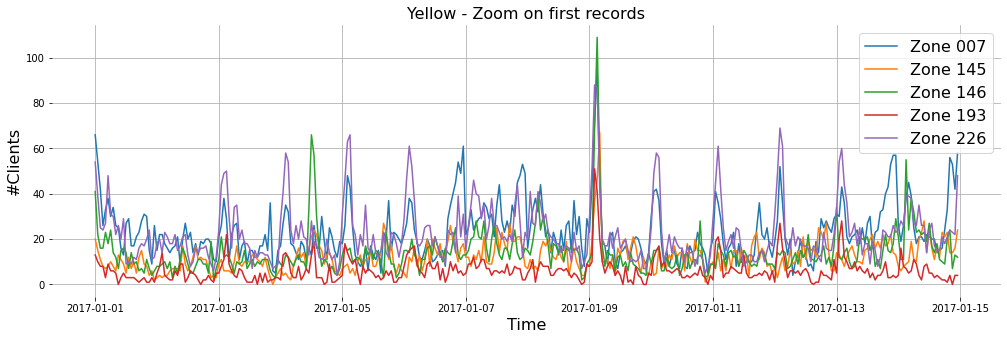

In [7]:
nb_records_to_display = 2*7*24 # display two weeks

fig, ax = plt.subplots(figsize=FIGSIZE)

for agent_id_col in selected_zones:
    plt.plot(utc_index[:nb_records_to_display],
            yellow[str(agent_id_col)].values[:nb_records_to_display],
            label="Zone {:0>3}".format(agent_id_col))
    

plt.title("Yellow - Zoom on first records", fontdict=FONT)
plt.xlabel("Time", fontdict=FONT)
plt.ylabel("#Clients", fontdict=FONT)

ax.set_frame_on(False)
plt.grid(True)
plt.legend(prop={"size": FONT["size"]})
plt.show()

### 1.4. Creating `train`/`test` sets

In [8]:
start = pd.to_datetime("2017-12-04 00:00")
train = yellow[:start]
test = yellow[start:pd.to_datetime("2017-12-17 23:00")]

## 2. Connect to craft ai api

Open a link to the craft ai API by creating a `client` based on user's token. 

If you do not have a token yet, <a href='https://beta.craft.ai/inspector'>create a project</a> (on chrome) and past your `Write API token` in a file named `.env` like the following:
```sh
 CRAFT_TOKEN=your-token
```

_This file should be at the root of your cloned project. You might have to rerun the `pipenv run notebook` after filling the `.env` file._

In [9]:
client = craft_ai.pandas.Client({
  "token": os.environ.get("CRAFT_TOKEN")
})

## 3. Setup Prediction

In this work each taxi zone is computed by an Agent. In other words, Agent `taxi_zone_007` is supposed to learn from zone 7's historical records to predict potential taxi needs in this zone.

### 3.1. Initiate Agents
First we create a DataFrame `agents` that will store zone ids, alongside with our agent ids and all kind of results. 

In [10]:
agents = pd.DataFrame(
    data={
        "zone": selected_zones,
        "agent_id": ["taxi_zone_{:0>3}".format(z) for z in selected_zones]
    }
)
agents.head()

,zone,agent_id
0,7,taxi_zone_007
1,145,taxi_zone_145
2,146,taxi_zone_146
3,193,taxi_zone_193
4,226,taxi_zone_226


It's now time to setup our agents' context. In this work the configuration context is shared by all agents. 

`CONFIGURATION` indicates to the API what are the inputs features and which feature(s) we want to predict.

In [11]:
# CONFIGURATION is the same for all agents
CONFIGURATION = {
    "context": {
        "day_of_week": {                # feature generated by the API from the DataFrame index 
            "type" : "day_of_week"
        },
        "time": {                       # feature generated by the API from the DataFrame index
            "type": "time_of_day"
        },
        "timezone": {                   # timezone for trip_counter      
            "type" : "timezone",        
        },
        "trip_counter": {               # taxi trips counter            
            "type": "continuous"
        }
    },
    "output": ["trip_counter"],         # the output is continuous
    "learning_period": 31536000,         # 1 year: 365d * 24h * 3600s
    "tree_max_depth": 10 
}

The following function `setup_agent` aims at creating an Agent on the API and to add the operations associated.

In [12]:
def setup_agent(row):
    """ Initiate Agent with the given id and 
        add the data associated with this zone
    """

    # Delete older version of the agent
    client.delete_agent(row.agent_id)

    # Add the new agent
    client.create_agent(CONFIGURATION, row.agent_id)

    # Add operations
    data = train[["timezone", str(row.zone)]]
    data.columns = ["timezone", "trip_counter"]
    client.add_agent_operations(row.agent_id, data)

    return True

In [13]:
%%time

agents["setup"] = agents.apply(setup_agent, axis=1)

CPU times: user 7.19 s, sys: 108 ms, total: 7.3 s
Wall time: 22 s


In [14]:
agents.head()

,zone,agent_id,setup
0,7,taxi_zone_007,True
1,145,taxi_zone_145,True
2,146,taxi_zone_146,True
3,193,taxi_zone_193,True
4,226,taxi_zone_226,True


### 3.2. Retrieve last decision tree

Each Agent learns from its operations. Then we ask the API for the last Decision Tree.

__This step is the most time consuming's one.__


Firstly we choose a timestamp where we want to retrieve our model. In this notebook we want to retrieve the `train` set last decision tree:

In [15]:
TS = train.index.astype(np.int64).values[-1] // 10**9 #get last timestamp

In [16]:
# API request. The training starts when the user asks for the decision tree.
get_DT = lambda agent_id : client.get_agent_decision_tree(agent_id, timestamp=TS)

In [17]:
%%time

agents['decision_tree'] = agents.agent_id.apply(get_DT)

CPU times: user 92 ms, sys: 57.6 ms, total: 150 ms
Wall time: 3min 24s


In [18]:
agents.head()

,zone,agent_id,setup,decision_tree
0,7,taxi_zone_007,True,"{'_version': '2.0.0', 'trees': {'trip_counter'..."
1,145,taxi_zone_145,True,"{'_version': '2.0.0', 'trees': {'trip_counter'..."
2,146,taxi_zone_146,True,"{'_version': '2.0.0', 'trees': {'trip_counter'..."
3,193,taxi_zone_193,True,"{'_version': '2.0.0', 'trees': {'trip_counter'..."
4,226,taxi_zone_226,True,"{'_version': '2.0.0', 'trees': {'trip_counter'..."


## 4. Decision's time !

Now that we have retrieved our models, we are able to predict the best place to find clients.


### 4.1. Decision Dataframe setup

First we setup the `DECISION_DF` where the prediction inputs are located. In this work `DECISION_DF` is quite simple: it's just an index with the `timezone` column. Indeed, columns `day_of_week` and `time` are computed by the API from the index.

To evaluate the predictions we are testing our agents on the `test` set. So we are testing our agents on the last 13 days of the year 2017.

In [19]:
# DECISION_DF is the same for all Agents as we want to compare taxi zones
DECISION_DF = pd.DataFrame(index=test.index)
DECISION_DF['timezone'] = DECISION_DF.index.strftime('%z')

### 4.2. Make Decisions

Ask each Agent to estimate the taxi need for their own `taxi_zone` thanks to the `DECISION_DF`.

In [20]:
def decide(tree):
    decision = client.decide_from_contexts_df(tree, DECISION_DF)
    return pd.Series({ c: decision[c].values for c in decision.columns })

In [21]:
agents_with_decisions = agents.merge(
    agents.decision_tree.apply(decide), 
    left_index=True, 
    right_index=True
)

agents_with_decisions.head(2)

,zone,agent_id,setup,decision_tree,trip_counter_predicted_value,trip_counter_confidence,trip_counter_decision_rules,trip_counter_nb_samples,trip_counter_decision_path,trip_counter_standard_deviation,trip_counter_min,trip_counter_max
0,7,taxi_zone_007,True,"{'_version': '2.0.0', 'trees': {'trip_counter'...","[23.096888, 33.56249, 41.12501, 32.835052, 18....","[0.8208492398262024, 0.787865936756134, 0.7695...","[[{'property': 'time', 'operator': '[in[', 'op...","[289, 288, 288, 582, 288, 288, 288, 288, 576, ...","[0-1-1-0-1-1-1-0-0, 0-1-1-1-0-0-1-0-0-0, 0-1-1...","[4.9438815, 8.889347, 12.127586, 11.098384, 6....","[15, 16, 18, 18, 9, 5, 6, 5, 4, 9, 6, 5, 5, 7,...","[36, 52, 72, 94, 47, 28, 24, 27, 37, 29, 24, 3..."
1,145,taxi_zone_145,True,"{'_version': '2.0.0', 'trees': {'trip_counter'...","[8.190315, 9.083334, 11.791664, 13.854168, 15....","[0.6991862654685974, 0.7018647193908691, 0.627...","[[{'property': 'time', 'operator': '[in[', 'op...","[289, 288, 288, 288, 576, 576, 1152, 1152, 115...","[0-1-1-0-1-0-0-1, 0-1-1-0-1-0-1-1, 0-1-1-1-1-0...","[3.4833593, 3.813601, 6.9341097, 7.191718, 9.0...","[3, 2, 3, 3, 4, 4, 4, 4, 4, 4, 4, 9, 6, 6, 6, ...","[20, 20, 37, 46, 67, 67, 52, 52, 52, 52, 31, 3..."


Each decision is explainable. You can analyse the tree directly in your <a href="https://integration.craft.ai/inspector/">project's inspector</a> (on chrome), or your can print the decision rule that has led to the decision.

In [22]:
# decision to explain:
agent_id_to_explain = 'taxi_zone_007'
decision_idx_to_explain = 0

line_to_explain = agents_with_decisions[agents_with_decisions.agent_id == agent_id_to_explain]

decision =  line_to_explain.trip_counter_predicted_value.values[0][decision_idx_to_explain]
        
rule_to_explain = line_to_explain.trip_counter_decision_rules.values[0][decision_idx_to_explain]

print('Agent {} has predicted {:0.4} clients in his zone,\nbecause '
      .format(agent_id_to_explain, decision),
      craft_ai.format_decision_rules(
          craft_ai.reduce_decision_rules(rule_to_explain)
      ))

Agent taxi_zone_007 has predicted 23.1 clients in his zone,
because  'time' in [0, 1[ and 'day_of_week' in [0, 1[


### 4.3. Observe results

In [23]:
# To display without timezone shifting
utc_test_index = pd.date_range('2017-12-04 00:00', 
                        "2017-12-17 23:00", freq="h") 

Reformat results:

In [24]:
predictions = pd.DataFrame(
                agents_with_decisions.trip_counter_predicted_value.tolist()
              ).T
predictions.columns = selected_zones_str
predictions.index = test.index
predictions.head()

,7,145,146,193,226
timestamp,,,,,
2017-12-04 00:00:00-05:00,23.096888,8.190315,12.197233,5.543253,25.476620
2017-12-04 01:00:00-05:00,33.562490,9.083334,12.312504,12.635417,39.916680
2017-12-04 02:00:00-05:00,41.125010,11.791664,14.031251,16.187498,47.833332
2017-12-04 03:00:00-05:00,32.835052,13.854168,18.104166,12.354170,42.145817
2017-12-04 04:00:00-05:00,18.979166,15.052089,13.270841,9.437499,20.895832


In [25]:
# predictions' standard deviation
stds = pd.DataFrame(
                agents_with_decisions.trip_counter_standard_deviation.tolist()
              ).T
stds.columns = selected_zones_str
stds.index = test.index

Static visualization:

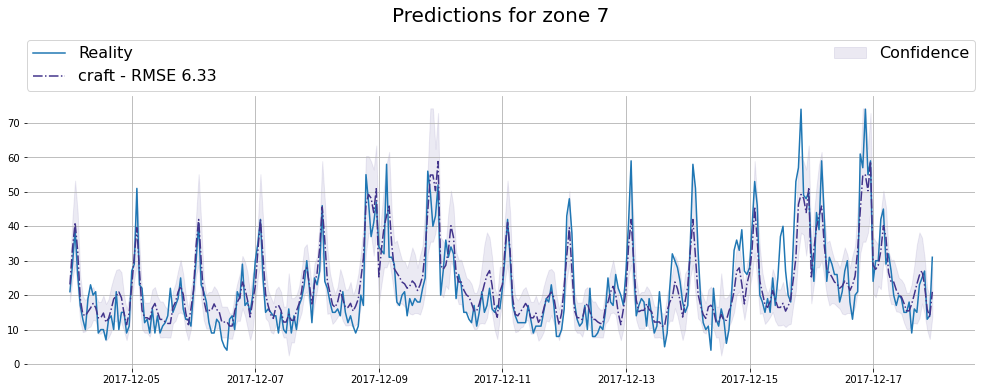

In [26]:
zone = "7"

plot_zone_results(zone, utc_test_index, 
                    test, predictions, stds)

To have a deeper analysis, please refer to `Benchmarks.ipynb`.

```python
#save results for benchmark analysis:
predictions.to_csv(PATH + 'craftai.csv')
stds.to_csv(PATH + 'craftai_std.csv')

```

## 5. Conclusion: Evaluate Best Taxi Zone 

Based on all Agents estimations, find the `taxi_zone` with the most persons looking for a taxi. 

In [27]:
def best_zone(row):
    return agents.zone.values[np.argmax(row.values)]

In [28]:
predictions['best_zone'] = predictions[selected_zones_str].apply(best_zone, axis=1)

predictions.sample(10).sort_index()

,7,145,146,193,226,best_zone
timestamp,,,,,,
2017-12-04 13:00:00-05:00,14.791664,16.659733,14.177090,4.114585,15.750001,145
2017-12-05 16:00:00-05:00,16.437490,17.666664,11.388871,3.368055,13.843740,145
2017-12-06 15:00:00-05:00,11.031247,17.541662,11.458341,3.291667,12.541671,145
2017-12-08 05:00:00-05:00,20.624994,15.499997,12.722219,10.333335,18.770828,7
2017-12-09 15:00:00-05:00,21.354172,19.291660,18.166666,4.864585,18.291670,7
2017-12-10 12:00:00-05:00,17.632656,16.785711,14.867355,4.112245,17.469395,7
2017-12-12 02:00:00-05:00,39.583320,11.104166,14.031251,14.812499,56.562520,226
2017-12-13 19:00:00-05:00,23.812500,19.229160,14.333331,4.750003,17.447916,7
2017-12-14 08:00:00-05:00,16.583340,17.979176,11.590284,7.770831,18.447905,226


In [29]:
predictions[predictions['best_zone']==145].head()

,7,145,146,193,226,best_zone
timestamp,,,,,,
2017-12-04 06:00:00-05:00,14.000000,17.796873,12.041668,7.763889,16.770840,145
2017-12-04 07:00:00-05:00,15.166670,17.796873,11.239584,7.763889,17.041672,145
2017-12-04 11:00:00-05:00,13.416665,21.895828,12.369786,6.395832,20.229166,145
2017-12-04 12:00:00-05:00,13.416665,16.659733,14.177090,6.312499,16.458328,145
2017-12-04 13:00:00-05:00,14.791664,16.659733,14.177090,4.114585,15.750001,145


Let's have a look to the results:

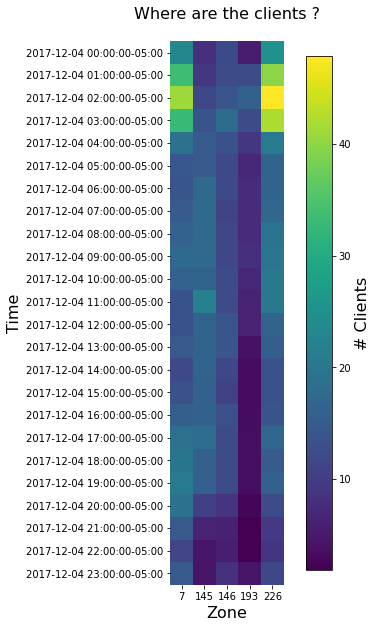

In [30]:
nb_hours_to_display = 24 # display the first day

plot_text = {
    'x_tick_labels': selected_zones,
    'y_tick_labels': predictions.index[:nb_hours_to_display],
    'title': 'Where are the clients ?',
    'xlabel': 'Zone',
    'ylabel': 'Time',
    'cbar_label': '# Clients'
}

plot_matshow(predictions[selected_zones_str][:nb_hours_to_display], plot_text)

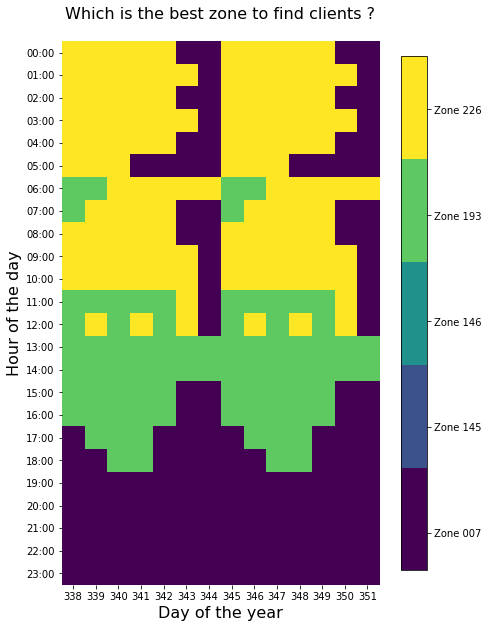

In [31]:
hours = ['{:0>2}:00'.format(h) for h in range(24)]
days = [str(d) for d in np.unique(predictions.index.dayofyear)]
mat = predictions.best_zone.values.reshape((14,24)).T

plot_text = {
    'x_tick_labels': days,
    'y_tick_labels': hours,
    'title': 'Which is the best zone to find clients ?',
    'xlabel': 'Day of the year',
    'ylabel': 'Hour of the day',
    'cbar_label': None
}

plot_matshow(mat, plot_text, selected_zones)

Thanks for reading this notebook until the end! 

 * If you want to work on more data you can check `Preprocessing.ipynb`.
 * To see the benchmarks it's with `Benchmarks.ipynb`.

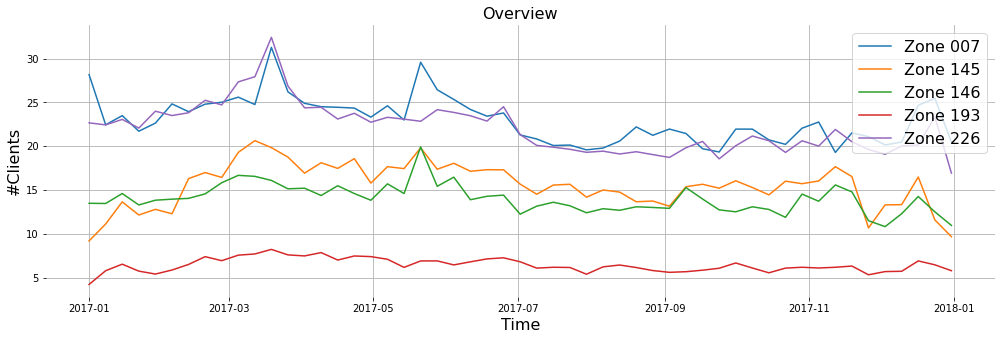

In [32]:
fig, ax = plt.subplots(figsize=FIGSIZE)

for agent_id_col in selected_zones:
    trend_df = yellow[str(agent_id_col)].resample('1w').mean()
    plt.plot(trend_df.index,
            trend_df.values,
            label="Zone {:0>3}".format(agent_id_col))
    
plt.title("Overview", fontdict=FONT)
plt.xlabel("Time", fontdict=FONT)
plt.ylabel("#Clients", fontdict=FONT)

ax.set_frame_on(False)
plt.grid(True)
plt.legend(prop={"size": FONT["size"]})
plt.show()